# iMLE performance

Reconstructing the `cat` state from measurements of the Husimi Q function. The cat state is defined as:

$$|\psi_{\text{cat}} \rangle = \frac{1}{\mathcal N} ( |\alpha \rangle + |-\alpha \rangle \big ) $$

with $\alpha=2$ and normalization $\mathcal N$.

## Husimi Q function measurements

The Husimi Q function can be obtained by calculating the expectation value of measuring the following operator:

$$\mathcal O_i = \frac{1}{\pi}|\beta_i \rangle \langle \beta_i|$$

where $|\beta_i \rangle $ are coherent states written in the Fock basis.


In [1]:
import numpy as np

from qutip import coherent, coherent_dm, expect, Qobj, fidelity, rand_dm
from qutip.wigner import wigner, qfunc

import tensorflow as tf

from tqdm.auto import tqdm

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

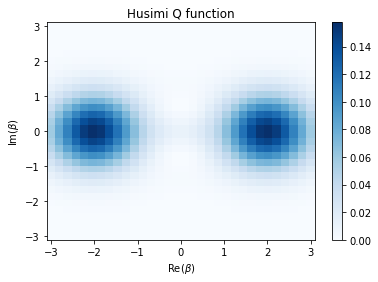

In [2]:
hilbert_size = 32
alpha = 2

psi = coherent(hilbert_size, alpha) + coherent(hilbert_size, -alpha)
psi = psi.unit() # The .unit() function normalizes the state to have unit trace

grid = 32
xvec = np.linspace(-3, 3, grid)
yvec = np.linspace(-3, 3, grid)

q = qfunc(psi, xvec, yvec, g=2)

cmap = "Blues"
im = plt.pcolor(xvec, yvec, q, vmin=0, vmax=np.max(q), cmap=cmap, shading='auto')
plt.colorbar(im)
plt.xlabel(r"Re($\beta$)")
plt.ylabel(r"Im($\beta$)")
plt.title("Husimi Q function")
plt.show()

# Construct the measurement operators and simulated data (without any noise)

In [3]:
X, Y = np.meshgrid(xvec, yvec)
betas = (X + 1j*Y).ravel()
m_ops = [coherent_dm(hilbert_size, beta) for beta in betas]
ops_numpy = [op.full() for op in m_ops]

data = expect(m_ops, psi)
rho_true = psi*psi.dag()

# Iterative maximum likelihood estimation

In [4]:
fidelities = []
max_iterations = 10000

rho = rand_dm(hilbert_size, 0.8)
fidelities.append(fidelity(rho_true, rho))
pbar = tqdm(range(max_iterations))


for i in range(max_iterations):
    guessed_val = expect(m_ops, rho)
    ratio = data / guessed_val

    R = Qobj(np.einsum("aij,a->ij", ops_numpy, ratio))
    rho = R * rho * R
    rho = rho / rho.tr()

    f = fidelity(rho, rho_true)
    fidelities.append(f)

    pbar.set_description("Fidelity iMLE {:.4f}".format(f))
    pbar.update()

Fidelity iMLE 0.9911: 100%|██████████| 10000/10000 [06:08<00:00, 29.70it/s]

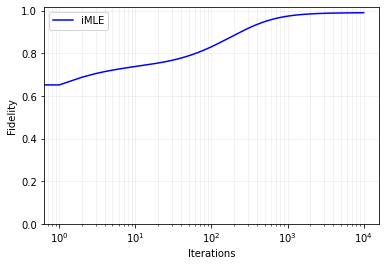

Fidelity iMLE 0.9911: 100%|██████████| 10000/10000 [06:20<00:00, 29.70it/s]

In [5]:
iterations = np.arange(len(fidelities))
plt.plot(iterations, fidelities, color="blue", label="iMLE")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Fidelity")
plt.ylim(0, 1.02)
plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.2)
plt.xscale('log')
plt.show()